<a href="https://colab.research.google.com/github/codelspak/Codelion_weekly_projects/blob/main/WK27_Mini_project_Kaggle_ML_Classification_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 설명<br>
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.<br>
<br>
1. PassengerId - A unique Id for each passenger. 
<br>Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. <br>People in a group are often family members, but not always.
2. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. <br>Passengers in cryosleep are confined to their cabins.
4. Cabin - The cabin number where the passenger is staying. <br>Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. Destination - The planet the passenger will be debarking to.
6. Age - The age of the passenger.
7. VIP - Whether the passenger has paid for special VIP service during the voyage.
8. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. Name - The first and last names of the passenger.
10. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

[Kaggle 노트북 출처](https://www.kaggle.com/competitions/spaceship-titanic)

# 가설 설정<br>
문제 상황이 다른 물체와 충돌로 인해 위기상황에 처한 우주선에서 다른 행성으로 **transported**된 승객을 예측한다는 점에서, rescue crew의 도움을 받지 못하는 상황에는 뭐가 있을까 고민해보았고, 다음의 가설을 세워봄.<br>
```
가설1. VIP를 우선으로 구출한다 
    - 따라서 VIP는 Transported될 확률이 낮고, 음의 상관관계를 가질 것이다
가설2. 구조대원들은 객실에 있는 승객을 밖으로 피신시키는 동안, 밖에 있는 승객들을 우선으로 구출한다
    - 따라서 RoomService 제외, FoodCourt/ShoppingMall/Spa/VRDeck에 돈을 낸 (객실 밖에 머무를 확률이 높은) 승객들은 Transported 확률이 더 낮다
가설3. Last name이 같으면 가족이다 / 가족단위 승객들은 서로를 도우면서 구출될 확률이 높아진다 (Name, PassengerId feature에서 파생)
    - 따라서 승객들 중 동일한 Last name을 가진 사람이 존재하면, Transported 확률이 낮다
가설4. HomePlanet/Destination은 Cabin 배정과 관련이 없고, 따라서 Transport 여부와 영향이 없다
가설5. Cryosleep에 해당하는 승객들은, 위기상황을 인지하고 적극적으로 도움을 청하기가 어려우므로 구출될 확률이 낮다
    - 따라서 Cryosleep 승객은 Transported될 확률이 높을 것이다
가설6. 나이가 어린 승객은 우선으로 구출한다
    - 따라서 Age가 낮으면 Transported될 확률도 낮고, 양의 상관관계를 가질 것이다
```

# 1. 필요한 라이브러리 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/test.csv')

In [3]:
df_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/sample_submission.csv')
df_submit.shape

(4277, 2)

In [4]:
train.shape, test.shape

((8693, 14), (4277, 13))

# 2. 데이터 EDA 및 전처리

### 2.1. 기본정보 확인

#### 중복값/결측치 확인
train/test data 중복값 없음. PassengerId/Transported를 제외한 모든 컬럼에서 약 2%씩 결측치를 갖고 있음.

사실상 2%는 그렇게 치명적으로 많은 수는 아님. <br>
1) 하지만, 각 feature간에 서로 다른 행에서 데이터가 결측 처리된 경우 실제 전처리가 필요한 샘플 (행의) 수는 75%에 육박함.<br>
2) 문제 분석 및 가설 설정 단계에서, HomePlanet/Destination을 제외한 모든 feature가 Transport 결과 여부에 영향을 미친다고 봄. <br>
<br>이 때 최종 Label data인 Transported는 결측된 값이 없으므로, 일부 feature는 결측되었지만 그 외 컬럼들이 갖는 샘플 데이터가 충분히 유의미하다 생각되므로, 삭제하기보다 각 feature별로 기준을 잡아 결측치를 채워주기로 결정함


In [5]:
train.isnull().mean() * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [6]:
# 만약 하나라도 결측치를 갖는 행을 모두 삭제한다면, 남은 데이터 shape은?
(len(train) - len(train.dropna(how = 'any'))), len(train.dropna(how = 'any'))*100/len(train)

(2087, 75.99217761417232)

In [7]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

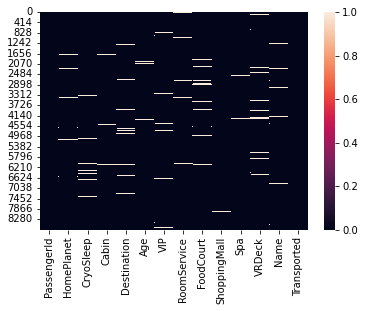

In [8]:
_= sns.heatmap(train.isnull())

In [9]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

#### 기술통계 확인

In [10]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [11]:
train.describe(include = ['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [12]:
# 위 기술통계에서 Gollux Reedall 이름을 가진 사람이 2명으로 나타남.
# 중복값 확인 후 필요시 제거
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [13]:
# 그럼 Gollux Reedall 샘플만 살짝 확인하고 넘어가자 - 그냥 우연히 이름이 같았나 봄
train[train['Name'] == 'Gollux Reedall']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
827,0881_01,Europa,False,D/32/S,TRAPPIST-1e,41.0,False,3103.0,3.0,0.0,31.0,26.0,Gollux Reedall,False
2852,3081_01,Europa,False,C/118/S,55 Cancri e,50.0,False,0.0,1547.0,0.0,1784.0,1.0,Gollux Reedall,True


#### 데이터 분포 확인

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [15]:
# 범주형 변수 unique value 확인
obj_col = train.select_dtypes(include = 'object').columns.tolist()
train[obj_col].nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

In [16]:
print(train['HomePlanet'].unique())
print(train['CryoSleep'].unique())
print(train['Destination'].unique())
print(train['VIP'].unique())

['Europa' 'Earth' 'Mars' nan]
[False True nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
[False True nan]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd8ba1da90>,
      dtype=object)

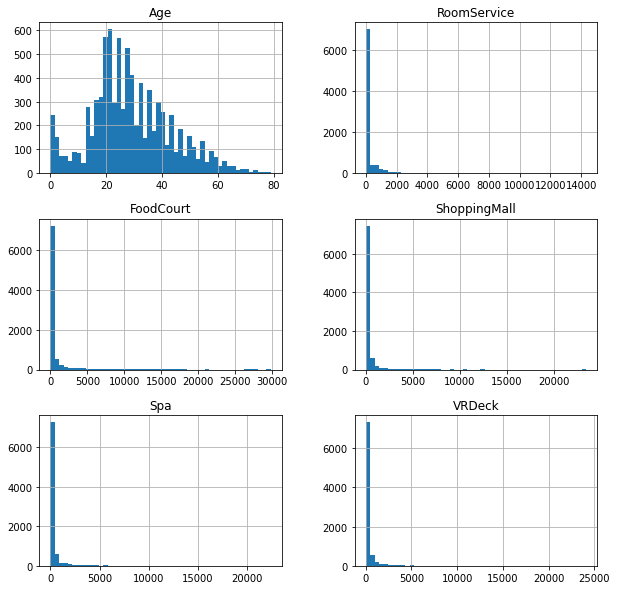

In [17]:
# 데이터 히스토그램 분포 확인 - 연속형/범주형 데이터 예상해보자
train.hist(bins = 50, figsize = (10,10))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd8b35b390>,
      dtype=object)

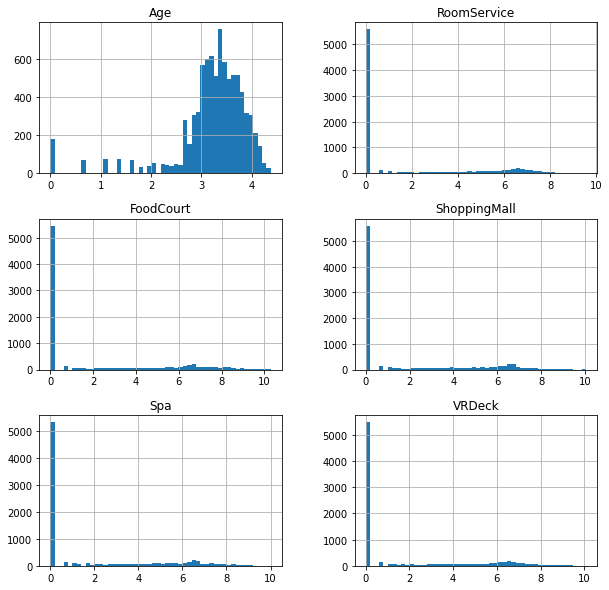

In [18]:
np.log1p(train.select_dtypes(include = 'number')).hist(bins = 50, figsize = (10,10))

위 히스토그램에서, 어메니티 지불 여부를 나타내는 5개 feature data가 분포 자체도 Imbalanced하고 scale이 너무 다름을 알 수 있음. <br>
일단 로그를 취했을 때, 위처럼 Scale이 비슷하고 분포도 정규분포처럼 가운데 산을 기준으로 좌우가 대칭에 비슷해진 형태를 보임.<br>
하지만 여전히 어메니티를 이용하지 않는 고객의 비율이 너무 높아 데이터가 imbalanced함. <br>얘는 예측값이 아니라 feature extraction에 사용될 원본 feature 중 하나일 뿐인데. under/oversampling을 통한 평탄화 작업이 필요할까? <br>이걸 알아보기 위해, 각 데이터가 0의 값을 가질 때 Transported 비율이 어떻게 되는지를 확인해봐야겠음.

In [19]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Imbalanced data handling을 위해 수업시간에 예시로 들었던 Credit card fraud detection과는, <br>최종적으로 구해야 할 (testset의 분포가 어떻게 구성되어 있을지 모르는) label data가 아니라, train data의 feature 분포가 치우쳐 있다는 게 다름

### 2.2. 가설 확인을 위한 데이터 EDA


In [20]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


#### 가설1. VIP는 Transport될 확률이 낮다 (True)
    - 구조대원들은 VIP를 우선으로 구출한다 
    - 따라서 VIP는 Transported될 확률이 낮을 것이다

In [21]:
# VIP 비율 - 일반 승객 대비 매우 소수
train.VIP.value_counts(normalize = True)*100

False    97.656066
True      2.343934
Name: VIP, dtype: float64

(0.0, 4500.0)

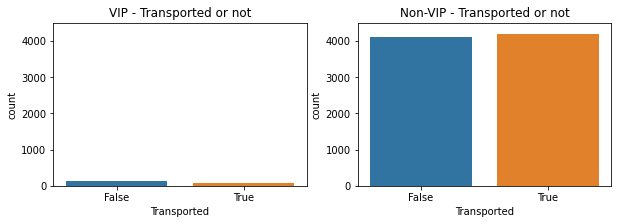

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

sns.countplot(data = train[train.VIP == True], x = 'Transported',ax = ax[0])
ax[0].set_title('VIP - Transported or not')
ax[0].set_ylim([0,4500])

sns.countplot(data = train[train.VIP == False], x = 'Transported',ax = ax[1])
ax[1].set_title('Non-VIP - Transported or not')
ax[1].set_ylim([0,4500])

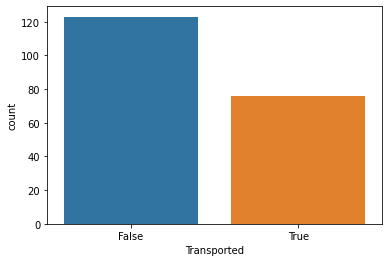

In [23]:
# VIP - Transported or not
_ = sns.countplot(data = train[train.VIP == True], x = 'Transported',)

VIP == True일 때, Transported된 비율이 약 30% 정도 낮은 반면<br>
VIP == False일 땐, 비슷한 확률로 Transported되었음을 알 수 있다<br>
이를 통해 1번의 가설처럼, VIP가 Transported를 결정하는데 중요한 feature로 작용함을 확인할 수 있었음.

추가로 VIP와 관련있는 다른 featur는 무엇이 있는지 알아보기 위해, 기존의 column으로부터 새로운 feature를 extract해서 관계를 알아봄.

###### 1) VIP - HomePlanet/Destination


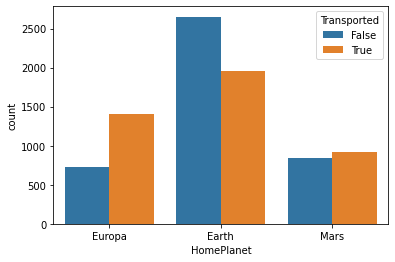

In [24]:
# 그래프1
_ = sns.countplot(data = train, x = 'HomePlanet', hue = 'Transported')

위 (그래프1)을 보면 HomePlanet에 따른 Transported 결과는 크게 두 가지로 분류 가능<br>
1. Mars : T - True/False 샘플 수가 거의 비슷함<br>
2. Europa/Earth : 경향 차이는 있지만, True/False 간에 최소 20% 이상의 차이가 보임<br>

그러나 아래 (그래프2)를 보면 Earth 출발 승객 중에는 VIP가 없으며, Mars/Europa 발 승객 중에는 아주 소수 존재함<br>
(그래프 3,4)를 통해서는 다음을 확인할 수 있었음<br>
1. (그래프4) - Europa/Earth 발 승객의 경우 (비율에는 차이가 있지만) VIP가 아닐 경우, Transported 케이스가 더 많음
2. (그래프3) - 소수이긴 하지만 Europa 발 VIP의 경우 구조된 경우가 더 많음. 위 1의 경우와 결과가 반대됨. 이를 통해 VIP는 Transport될 확률을 낮추는 중요한 feature임을 확인할 수 있음.
3. (그래프3, 4) - (가설5-2) 파트 EDA 결과에 따르면, HomePlanet은 Cabin deck의 종류와 관련이 있음. 대부분이 Europa 발 승객끼리 같은 deck에 머무르는 Europa와 달리, Earth/Mars 출발 승객은 두 개 혹은 세 개 행성 사람들끼리 섞여서 머무름.<br>
뒤에서 신경쓸 사람 없이 빠릿하게 탈출을 시도할 수 있는 조건의 사람들이 생존 확률이 높다는 결론을 내렸는데, 이와 연결지어 생각해볼 수 있을 것 같음. 

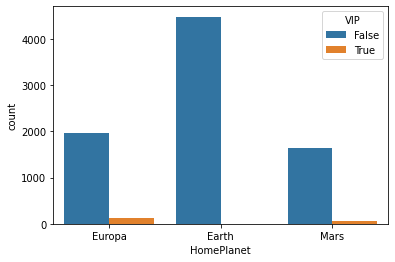

In [25]:
# 그래프2
_ = sns.countplot(data = train, x = 'HomePlanet', hue = 'VIP')

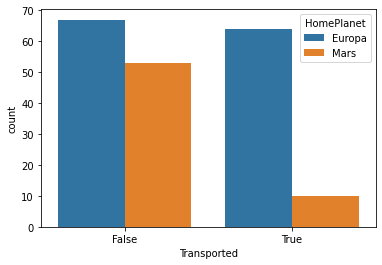

In [26]:
# 그래프3
_ = sns.countplot(data = train[train.VIP == True], x = 'Transported', hue = 'HomePlanet')

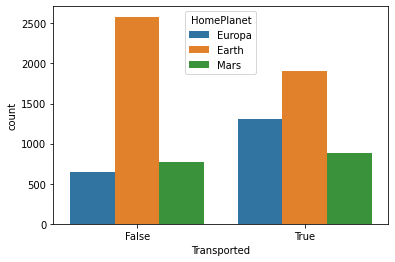

In [27]:
# 그래프4
_ = sns.countplot(data = train[train.VIP == False], x = 'Transported', hue = 'HomePlanet')

아래의 (그래프6)을 통해 HomePlanet과 동일하게, 모든 행성에 대해서 VIP는 생존 확률이 더 높음을 확인할 수 있다<BR>
(그래프 5,6,7)에서 T - True/False에 관계없이 각 행성 별 데이터가 비슷한 추세를 보이는 건, 그냥 종착 행성 별로 데이터 규모의 차이가 커서인 것으로 판단됨. 

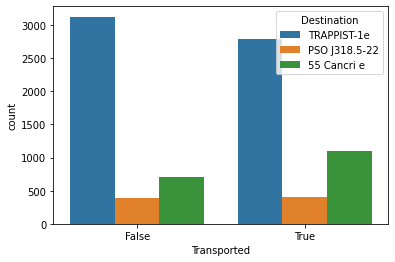

In [28]:
# 그래프5
_ = sns.countplot(data = train, x = 'Transported', hue = 'Destination')

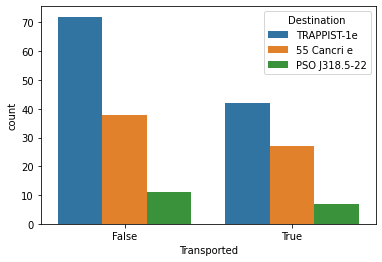

In [29]:
# 그래프6
_ = sns.countplot(data = train[train.VIP == True], x = 'Transported', hue = 'Destination')

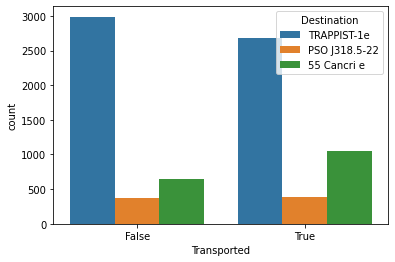

In [30]:
# 그래프7
_ = sns.countplot(data = train[train.VIP == False], x = 'Transported', hue = 'Destination')

In [31]:
pd.crosstab(index = train.Destination, columns = train.VIP)

VIP,False,True
Destination,,
55 Cancri e,1692,65
PSO J318.5-22,756,18
TRAPPIST-1e,5667,114


In [32]:
pd.crosstab(index = train.Destination, columns = train.Transported)

Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787


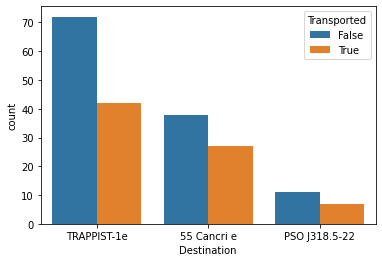

In [33]:
_ = sns.countplot(data = train[train.VIP == True], x = 'Destination', hue = 'Transported')

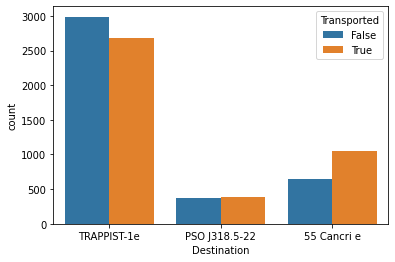

In [34]:
_ = sns.countplot(data = train[train.VIP == False], x = 'Destination', hue = 'Transported')

###### 2) VIP - Age

In [35]:
# 전체 데이터 Age 분포
train.Age.nunique(), train.Age.min(), train.Age.max(), test.Age.nunique(), test.Age.min(), test.Age.max() 

(80, 0.0, 79.0, 79, 0.0, 79.0)

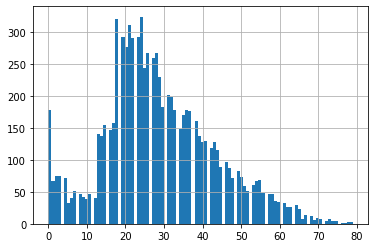

In [36]:
train.Age.hist(bins = 100)

In [37]:
# VIP Age 분포
train[train.VIP ==True].Age.nunique(), train[train.VIP ==True].Age.min(), train[train.VIP ==True].Age.max() 

(46, 18.0, 73.0)

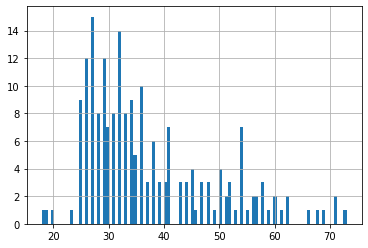

In [38]:
train[train.VIP ==True].Age.hist(bins = 100)

In [39]:
# Age 변수 - 범주화
train.loc[(train.Age>=0) & (train.Age<10), 'AgeBand'] = '0-9'
train.loc[(train.Age>=10) & (train.Age<20), 'AgeBand'] = '10-19'
train.loc[(train.Age>=20) & (train.Age<30), 'AgeBand'] = '20-29'
train.loc[(train.Age>=30) & (train.Age<40), 'AgeBand'] = '30-39'
train.loc[(train.Age>=40) & (train.Age<50), 'AgeBand'] = '40-49'
train.loc[(train.Age>=50) & (train.Age<60), 'AgeBand'] = '50-59'
train.loc[(train.Age>=60) & (train.Age<70), 'AgeBand'] = '60-69'
train.loc[(train.Age>=70) & (train.Age<80), 'AgeBand'] = '70-79'

In [40]:
pd.crosstab(index = train.AgeBand, columns = train.VIP)

VIP,False,True
AgeBand,,
0-9,658,0
10-19,1441,2
20-29,2641,58
30-39,1629,73
40-49,997,28
50-59,518,26
60-69,192,8
70-79,43,3


In [41]:
pd.crosstab(index = train[train.VIP ==False].AgeBand, columns = train[train.VIP ==False].Transported)

Transported,False,True
AgeBand,,
0-9,186,472
10-19,672,769
20-29,1408,1233
30-39,875,754
40-49,491,506
50-59,254,264
60-69,97,95
70-79,25,18


다만 VIP 구성을 보면 대부분이 20-50대로, 신체적 구성이 뛰어난 나이대에 몰려 있음<BR>
VIP 자체보다 나이대 or 탈출조건 등이 사실 더 유효한 영향을 미치는 게 아닌가 싶기도 했는데, <br>
위의 Non-VIP 나이대 별 Transported 여부를 보니 'VIP' 자체가 우선순위를 갖는 게 맞다고 판단됨

#### 가설2. FC/SM/Spa/VRDeck 이용 승객들은 Transport될 확률이 낮다 (True)
    - 구조대원들은 (객실에 있는 승객을 밖으로 불러내는 동안) 외부에 머무르던 승객들을 우선으로 구출한다
    - 따라서 객실 밖에 머무르고 있을 확률이 큰 FoodCourt/ShoppingMall/Spa/VRDeck 지불 고객들은 Transport 확률이 낮다
    - 반대로 객실에서 이용하는 RoomService 이용 고객은 Transport 확률이 높다

###### 1) VIP - RoomService/FoodCourt/ShoppingMall/Spa/VRDeck	

In [42]:
# paying the amenities : yes or no 파생변수생성
list_amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 

In [43]:
for feature in list_amenities :
    col_name = feature + "_cat"
    train.loc[train[feature].isnull(), col_name] = np.nan
    train.loc[train[feature]==0, col_name] = 0
    train.loc[train[feature]>0, col_name] = 1

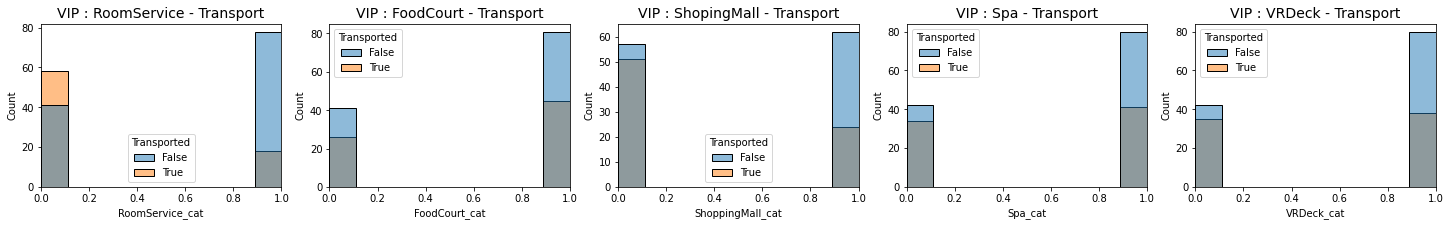

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (25,3))

sns.histplot(data = train[train.VIP == True], x = 'RoomService_cat', hue = 'Transported', ax = ax[0], )
ax[0].set_title('VIP : RoomService - Transport', fontsize =14)
ax[0].set_xlim([0, 1])

sns.histplot(data = train[train.VIP == True], x = 'FoodCourt_cat', hue = 'Transported', ax = ax[1], )
ax[1].set_title('VIP : FoodCourt - Transport', fontsize =14)
ax[1].set_xlim([0, 1])

sns.histplot(data = train[train.VIP == True], x = 'ShoppingMall_cat', hue = 'Transported', ax = ax[2], )
ax[2].set_title('VIP : ShopingMall - Transport', fontsize =14)
ax[2].set_xlim([0, 1])

sns.histplot(data = train[train.VIP == True], x = 'Spa_cat', hue = 'Transported', ax = ax[3], )
ax[3].set_title('VIP : Spa - Transport', fontsize =14)
ax[3].set_xlim([0, 1])

sns.histplot(data = train[train.VIP == True], x = 'VRDeck_cat', hue = 'Transported', ax = ax[4], )
ax[4].set_title('VIP : VRDeck - Transport', fontsize =14)
ax[4].set_xlim([0, 1])

plt.show()

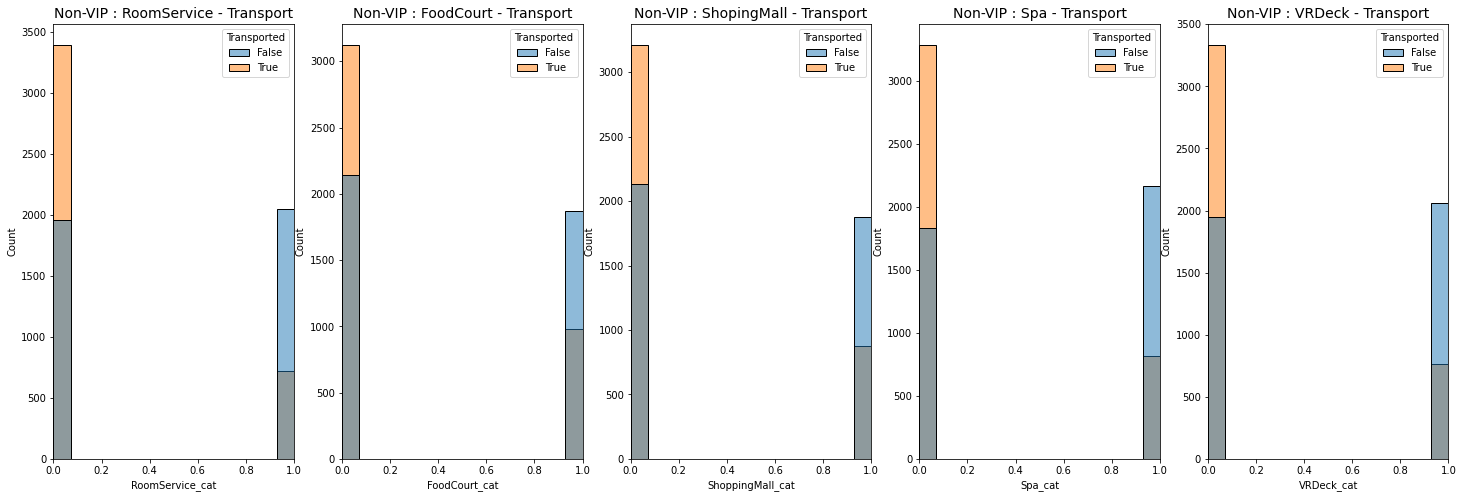

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (25,8))
sns.histplot(data = train[train.VIP == False], x = 'RoomService_cat', hue = 'Transported', ax = ax[0], )
ax[0].set_title('Non-VIP : RoomService - Transport', fontsize =14)
ax[0].set_xlim([0, 1])
sns.histplot(data = train[train.VIP == False], x = 'FoodCourt_cat', hue = 'Transported', ax = ax[1], )
ax[1].set_title('Non-VIP : FoodCourt - Transport', fontsize =14)
ax[1].set_xlim([0, 1])
sns.histplot(data = train[train.VIP == False], x = 'ShoppingMall_cat', hue = 'Transported', ax = ax[2], )
ax[2].set_title('Non-VIP : ShopingMall - Transport', fontsize =14)
ax[2].set_xlim([0, 1])
sns.histplot(data = train[train.VIP == False], x = 'Spa_cat', hue = 'Transported', ax = ax[3], )
ax[3].set_title('Non-VIP : Spa - Transport', fontsize =14)
ax[3].set_xlim([0, 1])
sns.histplot(data = train[train.VIP == False], x = 'VRDeck_cat', hue = 'Transported', ax = ax[4], )
ax[4].set_title('Non-VIP : VRDeck - Transport', fontsize =14)
ax[4].set_xlim([0, 1])
plt.show()

VIP/Non-VIP 별, 어메니티 이용 여부에 따른 Transported 결과 분포를 살펴보니<br>
1. VIP의 경우에는 어메니티에 관계없이 Transport되지 않고 구조된 확률이 더 높음<br>
2. 반면 일반 승객의 경우에는, 어메니티를 이용하지 않을 때 대비, 어메니티 비용을 지불했을 때 200% 이상으로 구조 확률이 높아지는 걸 확인<br>

```
<결론>
아래 두 가지 feature는 Transported class를 결정하는데 영향을 줌 
1. VIP - True (Transported - False 확률 증가)
2. RoomService/FoodCourt/ShoppingMall/Spa/VRDeck 어메니티 이용 (Transported - False 확률 증가)
```

###### 2) 어메니티 이용 수(num_of_amenities) - Transport
어메니티 이용 여부가 결과에 영향을 미친다는 걸 알게되니, <br>
1. 승객 중에 여러 어메니티를 이용하는 사람이 있는지, <br>
2. 있다면, 지불한 어메니티 이용 수에 따라 Transport or not 결과 분포에 차이가 있는지 확인하고 싶어짐

In [46]:
# 지불한 어메니티 수 - 파생변수 생성
list_amenities_cat = ['RoomService_cat', 'FoodCourt_cat', 'ShoppingMall_cat', 'Spa_cat', 'VRDeck_cat']
list_amenities_cat

['RoomService_cat',
 'FoodCourt_cat',
 'ShoppingMall_cat',
 'Spa_cat',
 'VRDeck_cat']

In [47]:
for col in list_amenities_cat:
    print(train[col].unique())

train['num_of_amenities'] = train['RoomService_cat'] + train['FoodCourt_cat'] + train['ShoppingMall_cat'] + train['Spa_cat'] + train['VRDeck_cat'] 

[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]


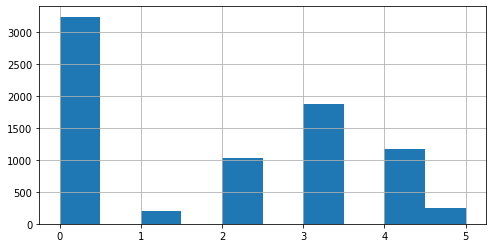

In [48]:
train['num_of_amenities'].hist(figsize = (8,4))

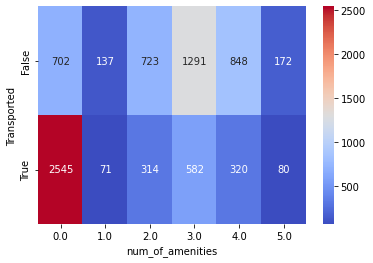

In [49]:
_ = sns.heatmap(pd.crosstab(index = train.Transported, columns = train['num_of_amenities']), cmap = 'coolwarm', annot = True, fmt = '.0f')

1. 어메니티 이용 여부는 생존에 영향을 미친다
    - num_of_amenities = 0일 때, 유일하게 Transported 된 경우가 많음
    - num_of_amenities > 0일 때, 반대로 Transported - False가 거의 2배에 가깝게 높음을 알 수 있음
2. 그렇다면 어메니티 이용 수에 따른 승객 분포에는 어떤 차이가 있을지 궁금해짐 

In [50]:
pd.concat([train.loc[train.num_of_amenities==0, 'Age'].describe(), train.loc[train.num_of_amenities>0, 'Age'].describe()], axis = 1,)


,Age,Age
count,3168.000000,4452.000000
mean,24.858902,31.758086
std,15.981260,12.597091
min,0.000000,13.000000
25%,14.000000,22.000000
50%,24.000000,29.000000
75%,35.000000,39.000000
max,78.000000,79.000000


In [51]:
train.loc[train.num_of_amenities==0].describe(include = 'object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,AgeBand
count,3247,3170,3160,3158,3193,3161,3175,3168
unique,3247,3,2,2437,3,2,3174,8
top,0001_01,Earth,True,G/1368/P,TRAPPIST-1e,False,Sharie Gallenry,20-29
freq,1,1540,2690,6,2063,3137,2,817


In [52]:
train.loc[train.num_of_amenities>0].describe(include = ['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,AgeBand
count,4538,4432,4432,4445,4429,4436,4430,4452
unique,4538,3,1,4028,3,2,4424,7
top,0002_01,Earth,False,E/13/S,TRAPPIST-1e,False,Loree Wolfernan,20-29
freq,1,2561,4432,5,3229,4281,2,1645


위 object type 기술통계를 통해<br>
1. 어메니티를 이용한 고객 중에는 Cryosleep 중인 고객이 없음 확인<br>
2. 그렇다면 어메니티를 이용하지 않았을 때 ,Cryosleep 여부에 따른 Transported 차이가 있을지 확인 필요

In [53]:
temp = train.loc[train.num_of_amenities==0, ['CryoSleep', 'Transported']]
df_cross = pd.crosstab(index = temp.CryoSleep, columns = temp.Transported)
df_cross

Transported,False,True
CryoSleep,,
False,183,287
True,496,2194


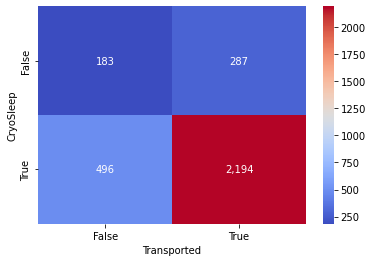

In [54]:
_ = sns.heatmap(df_cross, annot = True, fmt = ',.0f', cmap = 'coolwarm')

예상했던 것과 같이, 어메니티를 이용하지 않은 승객(n)중, 우주선을 탈출하지 못하고 Transported된 경우 대부분이 CryoSleep을 이용 중이었음<br>
    - n의 85.0%가 CryoSleep 이용 중<br>
    - n의 CryoSleep 이용 승객 중 81.6%가 Transported <br>
    - n 전체에선 88.6%가 Transported, 그 중에서 88.4%가 CryoSleep 이용 중<br>



In [55]:
temp = train.loc[train.num_of_amenities>0, ['CryoSleep', 'Transported']]
df_cross = pd.crosstab(index = temp.CryoSleep, columns = temp.Transported)
df_cross

Transported,False,True
CryoSleep,,
False,3096,1336


따라서 num_of_amenities ==0 이라는 조건 자체보다는 CryoSleep이 크게 영향을 미친 것으로 판단됨.<br>
하지만 num_of_amenities>0 일 때, CryoSleep 중인 승객이 없으므로, 이용중인 어메니티의 수 역시 영향이 없다고 할 수 없을 것으로 판단됨.

###### 3) AgeBand - RoomService/FoodCourt/ShoppingMall/Spa/VRDeck

In [56]:
# 나이대 별 생존확률
df_cross = pd.crosstab(index = train.AgeBand, columns = train.Transported, margins = True)
for ageband in df_cross.index.tolist() :
    df_cross.loc[ageband, False] = round(df_cross.loc[ageband, False]/df_cross.loc[ageband, 'All'] * 100, 1)
    df_cross.loc[ageband, True] = round(df_cross.loc[ageband, True]/df_cross.loc[ageband, 'All'] * 100, 1)
    df_cross.loc[ageband, 'All'] = round(df_cross.loc[ageband, 'All']/df_cross.loc[ageband, 'All'] * 100, 1)

df_cross

Transported,False,True,All
AgeBand,,,
0-9,28.9,71.1,100
10-19,46.7,53.3,100
20-29,53.1,46.9,100
30-39,54.1,45.9,100
40-49,49.3,50.7,100
50-59,50.6,49.4,100
60-69,52.4,47.6,100
70-79,56.5,43.5,100
All,49.6,50.4,100


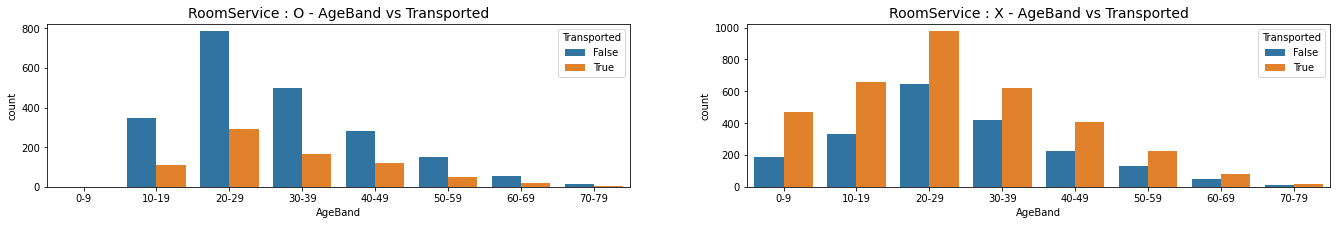

In [57]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23,3))

sns.countplot(data = train[train.RoomService_cat == 1], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[0])
ax[0].set_title('RoomService : O - AgeBand vs Transported', fontsize =14)

sns.countplot(data = train[train.RoomService_cat == 0], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[1])
ax[1].set_title('RoomService : X - AgeBand vs Transported', fontsize =14)

plt.show()

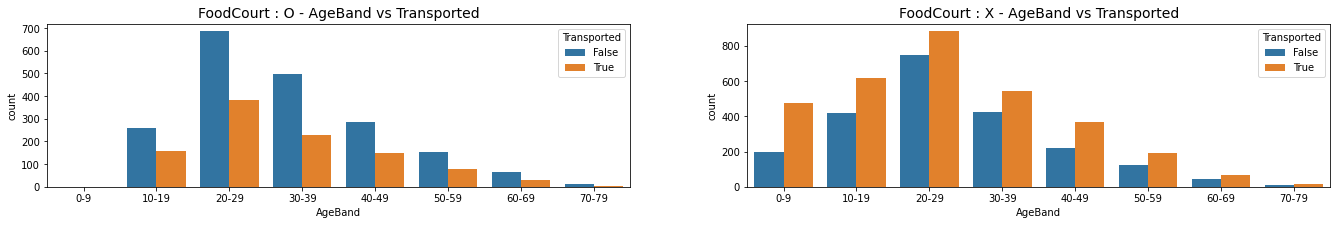

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23,3))

sns.countplot(data = train[train.FoodCourt_cat == 1], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[0])
ax[0].set_title('FoodCourt : O - AgeBand vs Transported', fontsize =14)

sns.countplot(data = train[train.FoodCourt_cat == 0], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[1])
ax[1].set_title('FoodCourt : X - AgeBand vs Transported', fontsize =14)

plt.show()

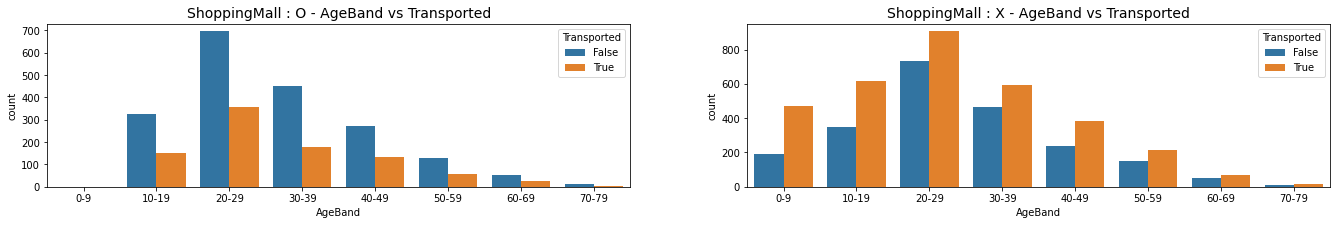

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23,3))

sns.countplot(data = train[train.ShoppingMall_cat == 1], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[0])
ax[0].set_title('ShoppingMall : O - AgeBand vs Transported', fontsize =14)

sns.countplot(data = train[train.ShoppingMall_cat == 0], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[1])
ax[1].set_title('ShoppingMall : X - AgeBand vs Transported', fontsize =14)

plt.show()

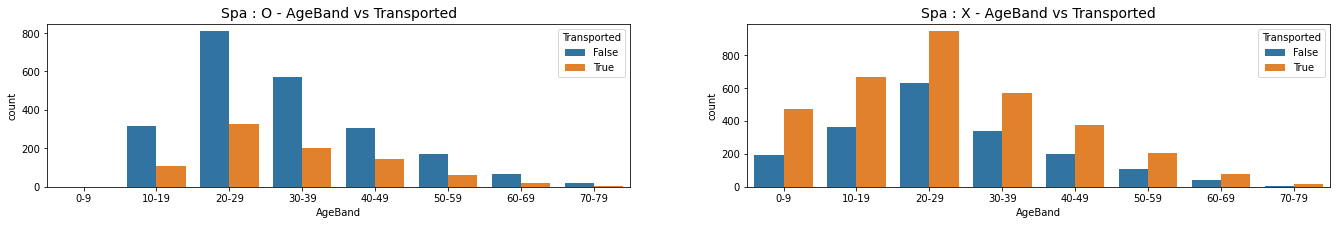

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23,3))

sns.countplot(data = train[train.Spa_cat == 1], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[0])
ax[0].set_title('Spa : O - AgeBand vs Transported', fontsize =14)

sns.countplot(data = train[train.Spa_cat == 0], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[1])
ax[1].set_title('Spa : X - AgeBand vs Transported', fontsize =14)

plt.show()

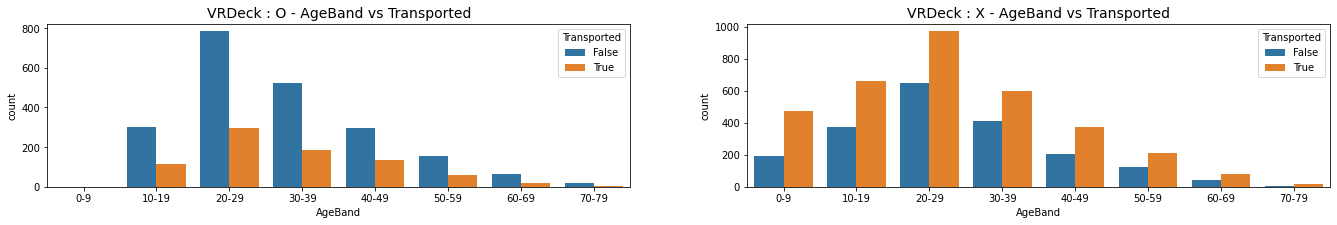

In [61]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23,3))

sns.countplot(data = train[train.VRDeck_cat == 1], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[0])
ax[0].set_title('VRDeck : O - AgeBand vs Transported', fontsize =14)

sns.countplot(data = train[train.VRDeck_cat == 0], x = 'AgeBand', hue = 'Transported',order = ['0-9','10-19','20-29','30-39',  '40-49', '50-59',  '60-69','70-79'], ax = ax[1])
ax[1].set_title('VRDeck : X - AgeBand vs Transported', fontsize =14)

plt.show()

AgeBand에 따른 분포 차이를 확인하려 하였지만, 각 Age 별 샘플 수의 차이로 기인할 뿐, 유의미한 점은 발견하지 못함<br>
다만, 생존 여부가 50% 안팎으로 거의 비슷한 다른 나이대에 비해, 아직 발달이 미숙한 10대 이하의 어린이들은 Transported, 즉 생존에 실패한 비율이 월등히 높았으며, 설정한 가설과 반대의 결과를 보였음<br>
다만, 어메니티 종류에 관계없이, 어메니티를 지불했을 경우, 모든 ageband에 대해 (지불하지 않을 때와 반대로) 생존 확률이 올라가는 동일한 결론을 내릴 수 있었음

#### 가설3. Name, PassengerId feature는 Transport 여부와 관계가 있다 (True)
    - Last name이 같으면 가족이다 / 가족단위 승객들은 서로를 도우면서 구출될 확률이 높아진다 
    - 따라서 승객들 중 동일한 Last name을 가진 사람이 존재하면, Transported 확률이 낮다
    -> EDA 결론 : is_alone == False : Transported 확률 증가함

###### 1) PassengerId -> group or alone / num_of_members


In [62]:
train['PassengerId'].head(3)

0    0001_01
1    0002_01
2    0003_01
Name: PassengerId, dtype: object

In [63]:
train['travel_group'] = train['PassengerId'].map(lambda x : x.split("_")[0])
train['number_ingroup'] = train['PassengerId'].map(lambda x : x.split("_")[1])
train[['PassengerId', 'travel_group', 'number_ingroup']].sample(5)


,PassengerId,travel_group,number_ingroup
596,0619_01,0619,01
7210,7703_01,7703,01
7361,7872_05,7872,05
5275,5627_01,5627,01
208,0221_06,0221,06


In [64]:
train.travel_group.nunique(), train.number_ingroup.unique()

(6217, array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype=object))

In [65]:
# group 별 여행 멤버 수가 여행을 미치는지 알아보기 위해, 파생변수 생성
temp = train.groupby('travel_group', as_index = False)['number_ingroup'].max()
temp.head(3)

,travel_group,number_ingroup
0,0001,01
1,0002,01
2,0003,02


In [66]:
for row_index in train.index.tolist() : 
    no_group = train.loc[row_index, 'travel_group']
    num_of_travelmembers = int(temp.loc[temp.travel_group == no_group, 'number_ingroup'])
    train.at[row_index, 'group_size'] = num_of_travelmembers

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,AgeBand,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat,num_of_amenities,travel_group,number_ingroup,group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,30-39,0.0,0.0,0.0,0.0,0.0,0.0,0001,01,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,20-29,1.0,1.0,1.0,1.0,1.0,5.0,0002,01,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,50-59,1.0,1.0,0.0,1.0,1.0,4.0,0003,01,2.0


In [67]:
# group/alone 파생변수
train.loc[train['group_size']==1, 'is_alone'] = True
train.loc[train['group_size']>1, 'is_alone'] = False

In [68]:
# 파생변수 데이터 유형 확인
train.loc[:, 'travel_group':].dtypes

travel_group       object
number_ingroup     object
group_size        float64
is_alone           object
dtype: object

In [69]:
# 분석 위해, 수치형으로 바꿔줌
train.travel_group = pd.to_numeric(train.travel_group, downcast = 'unsigned')
train.number_ingroup = pd.to_numeric(train.number_ingroup, downcast = 'unsigned')
train.group_size = pd.to_numeric(train.group_size, downcast = 'unsigned')
train.is_alone  = pd.to_numeric(train.is_alone , downcast = 'unsigned')

In [70]:
train.loc[:, 'travel_group':].dtypes

travel_group      uint16
number_ingroup     uint8
group_size         uint8
is_alone            bool
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd89f6a050>]],
      dtype=object)

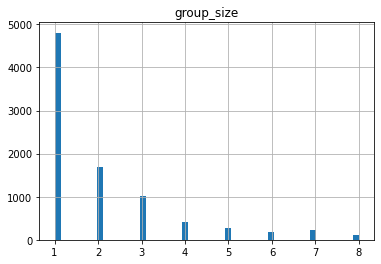

In [71]:
train[['group_size', 'Transported']].hist(bins = 50)

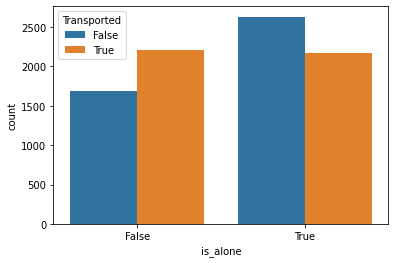

In [72]:
_ = sns.countplot(data = train[['is_alone', 'Transported']], x = 'is_alone', hue = 'Transported')

혼자 온 탑승객과 그룹 탑승객 사이 반대되는 추세를 보임<br>
하지만 설정한 가설과 달리, 오히려 혼자 왔을 때 transport되지 않고 구출된 경우의 수가 더 많음을 알 수 있음. <br>
앞의 ageband에 따른 transported 그래프를 보면, 발달이 미숙하거나 자립이 어려운 10세 미만 어린이에 한해 transported - True 경우가 현저하게 많음을 확인할 수 있었음.<br>
이와 연결지어 생각해보면 (서로 도와 생존 확률이 오를 거라 생각했던 것과 반대로) 빠릿빠릿하게 탈출을 위해 움직일 수 있는 조건이 생존에 영향을 미치는 것 같음.

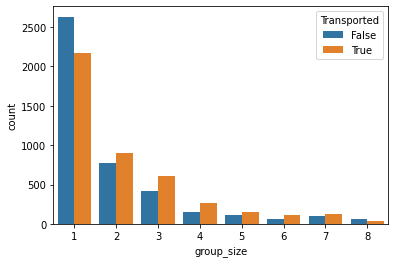

In [73]:
_ = sns.countplot(data = train[['group_size', 'Transported']], x = 'group_size', hue = 'Transported')

###### 2) Name -> Last name

In [74]:
train.loc[train.Name.notnull(), 'last_name'] = train.loc[train.Name.notnull(), 'Name'].map(lambda x : x.split(" ")[1])
train['last_name'].head()

0      Ofracculy
1          Vines
2         Susent
3         Susent
4    Santantines
Name: last_name, dtype: object

In [75]:
train['key_lastname'] = train['travel_group'].astype(str)+train['last_name']
train.key_lastname.head(3)

0    1Ofracculy
1        2Vines
2       3Susent
Name: key_lastname, dtype: object

In [76]:
temp = train[['key_lastname', 'Transported']].groupby('key_lastname', as_index = False)['Transported'].count()
temp.head(3)

,key_lastname,Transported
0,1000Harte,1
1,1001Llonovancis,1
2,1002Leste,3


In [77]:
train.loc[train.Name.isnull(), 'key_lastname'].unique()

array([nan], dtype=object)

In [78]:
# Name 컬럼에 결측치가 있어서, TypeError: cannot convert the series to <class 'int'>가 뜸. 결측치가 아닌 행에 대해서만 넣어주는 조건 세워주자
for row_index in train.loc[train.Name.notnull()].index.tolist() : 
        key = train.loc[row_index, 'key_lastname']
        no_family = int(temp.loc[temp.key_lastname == key, 'Transported'])
        if no_family == int(1) : 
            train.at[row_index, 'with_family'] = 0
        else : 
            train.at[row_index, 'with_family'] = 1

# 결측치 : 임의의 값 100으로 채워줌
train.with_family = train.with_family.fillna(100)
train.with_family = pd.to_numeric(train.with_family, downcast = 'unsigned')

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Spa_cat,VRDeck_cat,num_of_amenities,travel_group,number_ingroup,group_size,is_alone,last_name,key_lastname,with_family
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,1,True,Ofracculy,1Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1.0,1.0,5.0,2,1,1,True,Vines,2Vines,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,1.0,1.0,4.0,3,1,2,False,Susent,3Susent,1


In [79]:
# 불필요한 컬럼 삭제
del train['key_lastname']

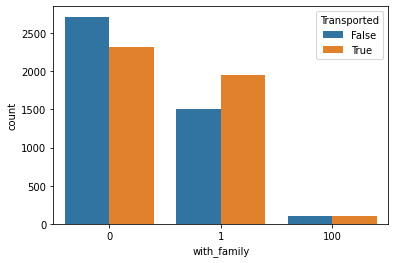

In [80]:
_ = sns.countplot(data = train[['with_family', 'Transported']], x = 'with_family', hue = 'Transported')

위의 is_alone 데이터 탐구에서 내린 결론과 마찬가지로, 역시 가족과 함께 왔을 때 transport 확률이 높은 경향을 보임.

In [81]:
# 필요없는 컬럼 삭제
del train['PassengerId']
del train['RoomService']
del train['FoodCourt']
del train['ShoppingMall']
del train['VRDeck']
del train['last_name']
del train['Spa']
del train['Name']

In [82]:
train.sample(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,AgeBand,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat,num_of_amenities,travel_group,number_ingroup,group_size,is_alone,with_family
2787,Earth,False,G/474/S,PSO J318.5-22,19.0,False,False,10-19,1.0,0.0,0.0,0.0,1.0,2.0,3006,1,1,True,0
4538,Earth,True,G/789/S,PSO J318.5-22,30.0,NaN,True,30-39,0.0,0.0,0.0,0.0,0.0,0.0,4827,1,1,True,0
6831,Europa,True,C/235/P,TRAPPIST-1e,2.0,False,False,0-9,0.0,0.0,0.0,0.0,0.0,0.0,7219,2,6,False,1


#### 가설4. HomePlanet/Destination은 Transport 여부와 영향이 없다 (HomePlanet  : False, Destination : True)
    -  출발/도착행성은 Cabin 배정과 관련이 없다. 따라서 확률적인 영향이 없다 

###### 1) Cabin - Transport
위의 가설을 확인하기 위해, 먼저 Cabin과 Transport 간 관계가 있는지 살펴보고자 함.<br>
데이터를 찾아보니 Port/Starboard는 선체 뒷편에서 볼 때 좌우 방향을 나타내는 것으로 사실상 큰 의미가 없어보임. <br>
다만 호텔룸이 보통 '층수 + 방 순서'처럼 구성되어 있는 걸 생각할 때, Cabin의 deck, num이 층수 등 유의미한 정보를 품고 있을 것 같아 확인해보기로 함<br>
* feature Cabin 정보 <br>
1. Cabin - The cabin number where the passenger is staying.<br>
2. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>




In [83]:
train.Cabin.isnull().sum()

199

In [84]:
# 결측치를 제외한 데이터에 대해서, split 통해 파생변수 생성
train.loc[train.Cabin.notnull(), 'cabin_deck'] = train.loc[train.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[0])
train.loc[train.Cabin.notnull(), 'cabin_num'] = train.loc[train.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[1])
train.loc[train.Cabin.notnull(), 'cabin_side'] = train.loc[train.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[2])
train.loc[:3, ['Cabin', 'cabin_deck', 'cabin_num', 'cabin_side']]

,Cabin,cabin_deck,cabin_num,cabin_side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S


In [85]:
train.cabin_deck.unique(), train.cabin_num.unique(), train.cabin_side.unique()

(array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object),
 array(['0', '1', '2', ..., '1892', '1893', '1894'], dtype=object),
 array(['P', 'S', nan], dtype=object))

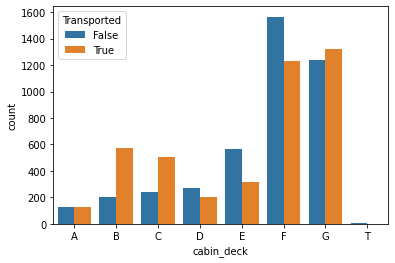

In [86]:
_ = sns.countplot(data = train[['Cabin', 'cabin_deck', 'cabin_num', 'cabin_side', 'Transported']], x = 'cabin_deck', hue = 'Transported', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

In [87]:
pd.crosstab(index = train.is_alone, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
is_alone,,,,,,,,
False,175,551,490,246,320,979,1027,0
True,81,228,257,232,556,1815,1532,5


In [88]:
pd.crosstab(index = train.with_family, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
with_family,,,,,,,,
0,100,271,293,251,577,1851,1585,4
1,149,492,440,217,280,870,916,0
100,7,16,14,10,19,73,58,1


In [89]:
pd.crosstab(index = train.VIP, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
VIP,,,,,,,,
False,215,725,687,438,846,2695,2493,5
True,35,42,41,31,15,29,0,0


deck이 뭘 의미하는걸까. 아직까진 유추할만한 경향성은 딱히 보이지 않음. 

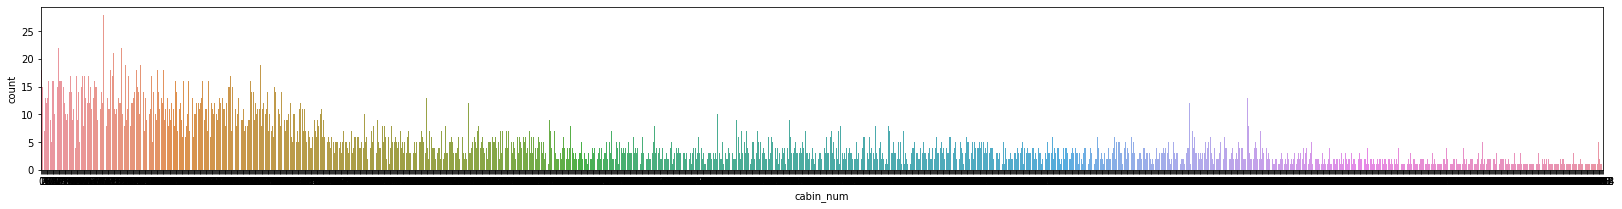

In [90]:
plt.figure(figsize = (28,3))
sns.countplot(data = train[['Cabin', 'cabin_deck', 'cabin_num', 'cabin_side', 'Transported']], x = 'cabin_num', )
plt.show()

In [91]:
train.cabin_num.value_counts().min(), train.cabin_num.value_counts().max()

(1, 28)

In [92]:
train.cabin_num.value_counts().sort_index(ascending = True)

0       18
1       15
10      12
100     12
1000     6
        ..
995      3
996      1
997      2
998      4
999      6
Name: cabin_num, Length: 1817, dtype: int64

객실 번호는 0번부터 999번까지, 1000개

In [93]:
# 같은 객실 번호를 가진 애들, 데이터 좀 뜯어 보겠음
train.cabin_num.value_counts()[train.cabin_num.value_counts()==2]

1482    2
1533    2
1152    2
1527    2
898     2
       ..
1741    2
1043    2
1329    2
887     2
610     2
Name: cabin_num, Length: 370, dtype: int64

In [94]:
train.iloc[[1482, 1533, 1152, 898], :]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,AgeBand,RoomService_cat,FoodCourt_cat,...,VRDeck_cat,num_of_amenities,travel_group,number_ingroup,group_size,is_alone,with_family,cabin_deck,cabin_num,cabin_side
1482,Earth,False,F/309/P,TRAPPIST-1e,25.0,False,False,20-29,1.0,0.0,...,0.0,3.0,1572,2,2,False,0,F,309,P
1533,Europa,False,C/59/P,TRAPPIST-1e,29.0,False,False,20-29,0.0,1.0,...,1.0,3.0,1625,2,2,False,1,C,59,P
1152,Earth,False,G/182/P,TRAPPIST-1e,20.0,False,True,20-29,1.0,1.0,...,0.0,2.0,1216,1,1,True,0,G,182,P
898,Earth,False,E/53/P,TRAPPIST-1e,20.0,False,False,20-29,1.0,0.0,...,0.0,1.0,968,1,1,True,0,E,53,P


In [95]:
# 필요없는 컬럼 추가 삭제
del train['number_ingroup']
del train['Cabin']

In [96]:
train.loc[train.cabin_num == '59', ['HomePlanet','Destination', 'Age', 'VIP','with_family', 'cabin_deck', 'cabin_num','cabin_side']]

,HomePlanet,Destination,Age,VIP,with_family,cabin_deck,cabin_num,cabin_side
248,Earth,TRAPPIST-1e,63.0,False,0,F,59,P
278,Earth,TRAPPIST-1e,18.0,False,0,F,59,S
311,Earth,55 Cancri e,15.0,False,0,G,59,P
360,Earth,TRAPPIST-1e,18.0,False,0,G,59,S
776,Earth,TRAPPIST-1e,13.0,False,0,E,59,S
1532,Europa,55 Cancri e,19.0,False,1,C,59,P
1533,Europa,TRAPPIST-1e,29.0,False,1,C,59,P
1572,Europa,TRAPPIST-1e,38.0,False,0,D,59,S
1780,Europa,TRAPPIST-1e,50.0,False,0,D,59,P
1782,Europa,55 Cancri e,19.0,False,1,D,59,P


In [97]:
train.cabin_num.value_counts()[train.cabin_num.value_counts()==5]

593     5
1156    5
935     5
1442    5
926     5
       ..
1490    5
530     5
582     5
900     5
1466    5
Name: cabin_num, Length: 151, dtype: int64

In [98]:
train.loc[[593, 1156], 'cabin_num']

593     92
1156    87
Name: cabin_num, dtype: object

In [99]:
train.loc[train.cabin_num == '92', ['HomePlanet','Destination', 'Age', 'VIP','with_family', 'cabin_deck', 'cabin_num','cabin_side']]

,HomePlanet,Destination,Age,VIP,with_family,cabin_deck,cabin_num,cabin_side
376,Earth,TRAPPIST-1e,18.0,False,0,F,92,P
481,NaN,TRAPPIST-1e,35.0,False,0,F,92,S
591,Earth,TRAPPIST-1e,58.0,False,0,G,92,S
592,Earth,TRAPPIST-1e,7.0,False,1,G,92,S
593,Earth,55 Cancri e,3.0,False,1,G,92,S
1185,Mars,TRAPPIST-1e,27.0,False,0,E,92,S
2127,Europa,TRAPPIST-1e,18.0,False,0,B,92,S
2377,Europa,TRAPPIST-1e,30.0,False,0,C,92,S
2728,Europa,55 Cancri e,54.0,True,1,B,92,P
2729,Europa,TRAPPIST-1e,51.0,False,0,B,92,P


위 테이블에서 문득 (Europa - ABC) (Mars - EFG) 인 것 같은 공통점이 보임<BR>
행성과 Cabin이 관계가 있을 수도 있겠다는 생각이 듦. <br>
아래와 같이 crosstab을 통해 확인해 본 결과, Destination은 관계가 없지만, 출발 행성은 deck 종류에 영향을 미친다는 걸 알 수 있었음

###### 2) cabin_deck - HomePlanet 

In [100]:
train.cabin_deck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: cabin_deck, dtype: int64

In [101]:
# groupsize에 따라 cabin_deck 영향이 있는지
pd.crosstab(index = train.group_size, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
group_size,,,,,,,,
1,81,228,257,232,556,1815,1532,5
2,64,281,203,156,167,438,326,0
3,61,104,100,32,84,316,305,0
4,36,90,63,14,18,108,77,0
5,8,43,52,19,23,23,83,0
6,6,6,52,11,13,5,77,0
7,0,27,20,14,15,49,99,0
8,0,0,0,0,0,40,60,0


In [102]:
pd.crosstab(index = train.HomePlanet, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0,0,0,0,395,1614,2498,0
Europa,252,766,734,186,128,0,0,4
Mars,0,0,0,282,330,1110,0,0


In [103]:
pd.crosstab(index = train.HomePlanet, columns = train.cabin_side)

cabin_side,P,S
HomePlanet,,
Earth,2270,2237
Europa,955,1115
Mars,888,834


In [104]:
pd.crosstab(index = train.Destination, columns = train.cabin_deck)

cabin_deck,A,B,C,D,E,F,G,T
Destination,,,,,,,,
55 Cancri e,108,333,317,113,116,398,365,0
PSO J318.5-22,2,3,13,17,41,241,461,0
TRAPPIST-1e,142,426,405,338,696,2088,1688,5


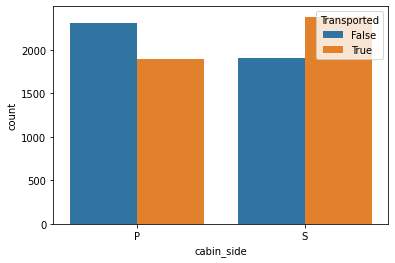

In [105]:
# 시각화해서 확인
_ = sns.countplot(data = train[['cabin_deck', 'cabin_num', 'cabin_side', 'Transported']], x = 'cabin_side', hue = 'Transported')

In [106]:
pd.crosstab(index = train.VIP, columns = train.cabin_side)

cabin_side,P,S
VIP,,
False,4011,4093
True,102,91


In [107]:
pd.crosstab(index = train.AgeBand, columns = train.cabin_side)

cabin_side,P,S
AgeBand,,
0-9,333,333
10-19,694,747
20-29,1392,1310
30-39,830,863
40-49,509,518
50-59,243,299
60-69,101,103
70-79,22,22


위의 정보처럼 P와 S는 단순히 좌우에 관한 개념으로, 승객의 정보와는 관련이 없어보임<BR>
다만, P/S에 따른 Transported 추세가 반대되는 걸 봐서, 비상탈출구 등이 P쪽에 가깝고, 따라서 생존 확률이 더 높지 않을까 예상해볼 수 있음

###### 3) cabin_num

In [108]:
df_cross = pd.crosstab(index = train.HomePlanet, columns = train.cabin_num, 
                                  margins = True).loc[pd.crosstab(index = train.HomePlanet, columns = train.cabin_num, margins = True).index == 'All', :'999']
num_people_inacabin = df_cross.values.tolist()

In [109]:
np.min(num_people_inacabin), np.max(num_people_inacabin)

(1, 28)

In [110]:
df_cross.T.sort_values(by = 'All').tail(5)

HomePlanet,All
cabin_num,
19,20
86,20
176,21
97,21
82,28


In [111]:
train.loc[train.cabin_num == '82', ['HomePlanet','Destination', 'Age', 'VIP','with_family', 'cabin_deck', 'cabin_num','cabin_side', 'travel_group']]

,HomePlanet,Destination,Age,VIP,with_family,cabin_deck,cabin_num,cabin_side,travel_group
326,Mars,TRAPPIST-1e,26.0,False,1,F,82,P,368
327,Mars,TRAPPIST-1e,61.0,False,1,F,82,P,368
492,Earth,55 Cancri e,1.0,False,1,G,82,P,531
493,Earth,55 Cancri e,NaN,False,1,G,82,P,531
525,Earth,TRAPPIST-1e,22.0,False,0,G,82,S,561
1223,Earth,55 Cancri e,2.0,False,1,E,82,P,1304
1224,Earth,TRAPPIST-1e,4.0,False,0,E,82,P,1304
1225,Earth,TRAPPIST-1e,10.0,False,1,E,82,P,1304
1226,Earth,TRAPPIST-1e,9.0,False,1,E,82,P,1304
1227,Earth,TRAPPIST-1e,37.0,False,1,E,82,P,1304


위의 정보를 종합해 볼 때, cabin_num는 고유한 숫자가 아니라 deck과의 결합을 통해 유니크한 값이 되는 피쳐임. <br>
게다가 앞에서 PassengerId로부터 파생한 travel_group과도 맥락을 함께하기 때문에 (같이 여행온 사람들은, 같은 cabin에 묵는듯), 해당 컬럼은 의미가 없다 판단하여 삭제하기로 함

###### 4) cabin_deck - cabin_side 
위의 테이블을 보다보니 뭔가 cabin_deck/num는 합쳐져서 의미를 가지는데, cabin_side는 deck/num에 의해 결정된 방에 의해 결과적으로 나오는 무의미한 정보같은 느낌이 듦. 한 번 확인해보겠음

In [112]:
pd.crosstab(index = train.cabin_deck, columns = train.cabin_side)

cabin_side,P,S
cabin_deck,,
A,117,139
B,353,426
C,341,406
D,248,230
E,429,447
F,1438,1356
G,1276,1283
T,4,1


In [113]:
# 임의의 방 넘버를 지정해주었을 땐
pd.crosstab(index = train.loc[train.cabin_num == '100', 'cabin_deck'], columns = train.loc[train.cabin_num == '100', 'cabin_side'])

cabin_side,P,S
cabin_deck,,
A,0,2
B,0,1
C,1,2
D,1,1
E,0,1
F,2,1


In [114]:
pd.crosstab(index = train.loc[train.cabin_num == '500', 'cabin_deck'], columns = train.loc[train.cabin_num == '500', 'cabin_side'])

cabin_side,P,S
cabin_deck,,
E,1,0
F,0,2
G,1,2


In [115]:
pd.crosstab(index = train.loc[train.cabin_num == '72', 'cabin_deck'], columns = train.loc[train.cabin_num == '72', 'cabin_side'])

cabin_side,P,S
cabin_deck,,
A,1,1
B,1,0
C,1,2
D,1,1
E,1,1
F,1,1
G,3,0


In [116]:
pd.crosstab(index = train.loc[train.cabin_num == '898', 'cabin_deck'], columns = train.loc[train.cabin_num == '898', 'cabin_side'])

cabin_side,P
cabin_deck,
F,1
G,1


위와 같이 몇 개 데이터를 확인해 본 결과, 그냥 우연에 의한 느낌이었을 뿐, 처음에 예상했던 것처럼 P/S는 그냥 좌우를 의미하는 게 맞음. <BR>
앞에서 말한 이유로 더 이상 필요없다 여겨지는 cabin_num는 삭제해줌

In [117]:
del train['cabin_num']

#### 가설5.Cryosleep 이용자는 Transport될 확률이 높다 (True)
    - Cryosleep에 해당하는 승객들은, 위기상황을 인지하고 적극적으로 도움을 청하기가 어려우므로 구출될 확률이 낮다
    - 따라서 Cryosleep 승객은 Transported될 확률이 높을 것이다


###### 1) VIP - CryoSleep

In [118]:
vip_cryo = pd.crosstab(index = train.CryoSleep, columns = train.VIP)
vip_cryo

VIP,False,True
CryoSleep,,
False,5143,175
True,2941,21


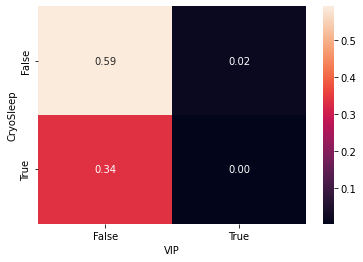

In [119]:

_ = sns.heatmap(vip_cryo/len(train), annot = True, fmt = ',.2f' )


In [120]:
# VIP 중 CryoSleep 승객의 비율
round(train.loc[train.VIP == True, 'CryoSleep'].value_counts(normalize = True)*100,3)

False    89.286
True     10.714
Name: CryoSleep, dtype: float64

VIP 중 약 12%가 CryoSleep 중인 것을 알 수 있음<br>
여기서 드는 의문은, VIP Transported 여부에 따라 CryoSleep 비율의 차이가 있을까? <br>
만약 CryoSleep 중인 VIP 승객의 비율이 Transported 케이스에서 현저하게 높다면, 이는 (가설5)의 검증과도 연결이 될 듯

In [121]:
train.loc[(train.VIP == True)&(train.CryoSleep == True), 'Transported'].value_counts()

True    21
Name: Transported, dtype: int64

In [122]:
pd.crosstab(index = train.loc[(train.VIP == True)].CryoSleep, columns = train.loc[(train.VIP == True)].Transported)

Transported,False,True
CryoSleep,,
False,121,54
True,0,21


위 집계 결과를 보면, VIP 중 CryoSleep에 참여한 승객은 모두 Transported되었으며, 이는 (가설5)와도 일맥상통함

###### 2) 전체 - CryoSleep


In [123]:
df_cross = pd.crosstab(index = train.CryoSleep, columns = train.Transported)
df_cross

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


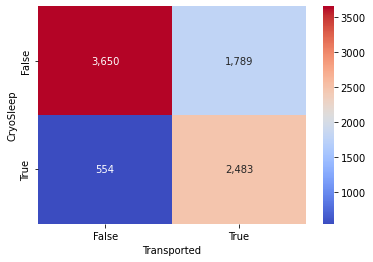

In [124]:
_ = sns.heatmap(df_cross, cmap = 'coolwarm', annot = True, fmt = ',.0f')

#### 가설6. Age가 어리면 Transport될 확률이 낮다 
    - 나이가 어린 승객은 우선으로 구출한다
    - 따라서 Age가 낮으면 Transported될 확률도 낮고, 양의 상관관계를 가질 것이다

In [125]:
# 나이대 별 생존확률
df_cross = pd.crosstab(index = train.AgeBand, columns = train.Transported, margins = True)
for ageband in df_cross.index.tolist() :
    df_cross.loc[ageband, False] = round(df_cross.loc[ageband, False]/df_cross.loc[ageband, 'All'] * 100, 1)
    df_cross.loc[ageband, True] = round(df_cross.loc[ageband, True]/df_cross.loc[ageband, 'All'] * 100, 1)
    df_cross.loc[ageband, 'All'] = round(df_cross.loc[ageband, 'All']/df_cross.loc[ageband, 'All'] * 100, 1)

df_cross

Transported,False,True,All
AgeBand,,,
0-9,28.9,71.1,100
10-19,46.7,53.3,100
20-29,53.1,46.9,100
30-39,54.1,45.9,100
40-49,49.3,50.7,100
50-59,50.6,49.4,100
60-69,52.4,47.6,100
70-79,56.5,43.5,100
All,49.6,50.4,100


앞의 (가설2-3)에서, Age가 어릴 때 오히려 Transported된 경우의 수가 많음을 확인하였음. <br>
AgeBand에 따른 분포 차이는 각 Age 별 샘플 수의 차이로 기인할 뿐, 10세 미만의 어린이를 제외하면, 나이대에 무관하게 생존 여부는 50% 안팎으로 거의 비슷하며 별다른 유의미한 점은 발견하지 못함

### 2.3. test 컬럼 조정

In [126]:
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,AgeBand,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat,num_of_amenities,travel_group,group_size,is_alone,with_family,cabin_deck,cabin_side
0,Europa,False,TRAPPIST-1e,39.0,False,False,30-39,0.0,0.0,0.0,0.0,0.0,0.0,1,1,True,0,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,True,20-29,1.0,1.0,1.0,1.0,1.0,5.0,2,1,True,0,F,S


In [127]:
# Age 변수 - 범주화
test.loc[(test.Age>=0) & (test.Age<10), 'AgeBand'] = '0-9'
test.loc[(test.Age>=10) & (test.Age<20), 'AgeBand'] = '10-19'
test.loc[(test.Age>=20) & (test.Age<30), 'AgeBand'] = '20-29'
test.loc[(test.Age>=30) & (test.Age<40), 'AgeBand'] = '30-39'
test.loc[(test.Age>=40) & (test.Age<50), 'AgeBand'] = '40-49'
test.loc[(test.Age>=50) & (test.Age<60), 'AgeBand'] = '50-59'
test.loc[(test.Age>=60) & (test.Age<70), 'AgeBand'] = '60-69'
test.loc[(test.Age>=70) & (test.Age<80), 'AgeBand'] = '70-79'

In [128]:
# 가설2-1
# paying the amenities : yes or no 파생변수생성
list_amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 

for feature in list_amenities :
    col_name = feature + "_cat"
    test.loc[test[feature].isnull(), col_name] = np.nan
    test.loc[test[feature]==0, col_name] = 0
    test.loc[test[feature]>0, col_name] = 1


# 가설2-2
# 지불한 어메니티 수 - 파생변수 생성
list_amenities_cat = ['RoomService_cat', 'FoodCourt_cat', 'ShoppingMall_cat', 'Spa_cat', 'VRDeck_cat']

for col in list_amenities_cat:
    print(test[col].unique())

test['num_of_amenities'] = test['RoomService_cat'] + test['FoodCourt_cat'] + test['ShoppingMall_cat'] + test['Spa_cat'] + test['VRDeck_cat'] 


[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]


In [129]:
# 가설 3-1
test['travel_group'] = test['PassengerId'].map(lambda x : x.split("_")[0])
test['number_ingroup'] = test['PassengerId'].map(lambda x : x.split("_")[1])


In [130]:
# 가설4
# group 별 여행 멤버 수가 여행을 미치는지 알아보기 위해, 파생변수 생성
temp = test.groupby('travel_group', as_index = False)['number_ingroup'].max()

for row_index in test.index.tolist() : 
    no_group = test.loc[row_index, 'travel_group']
    num_of_travelmembers = int(temp.loc[temp.travel_group == no_group, 'number_ingroup'])
    test.at[row_index, 'group_size'] = num_of_travelmembers

# group/alone 파생변수
test.loc[test['group_size']==1, 'is_alone'] = True
test.loc[test['group_size']>1, 'is_alone'] = False

# 분석 위해, 수치형으로 바꿔줌
test.travel_group = pd.to_numeric(test.travel_group, downcast = 'unsigned')
test.number_ingroup = pd.to_numeric(test.number_ingroup, downcast = 'unsigned')
test.group_size = pd.to_numeric(test.group_size, downcast = 'unsigned')
test.is_alone  = pd.to_numeric(test.is_alone , downcast = 'unsigned')

In [131]:
# 계속 가설4
test.loc[test.Name.notnull(), 'last_name'] = test.loc[test.Name.notnull(), 'Name'].map(lambda x : x.split(" ")[1])
test['key_lastname'] = test['travel_group'].astype(str)+test['last_name']

temp = test[['key_lastname', 'is_alone']].groupby('key_lastname', as_index = False)['is_alone'].count()

# with_family
# Name 컬럼에 결측치가 있어서, TypeError: cannot convert the series to <class 'int'>가 뜸. 결측치가 아닌 행에 대해서만 넣어주는 조건 세워주자
for row_index in test.loc[test.Name.notnull()].index.tolist() : 
        key = test.loc[row_index, 'key_lastname']
        no_family = int(temp.loc[temp.key_lastname == key, 'is_alone'])
        if no_family == int(1) : 
            test.at[row_index, 'with_family'] = 0
        else : 
            test.at[row_index, 'with_family'] = 1



In [132]:
# 계속 가설4
# 결측치 : 임의의 값 100으로 채워줌
test.with_family = test.with_family.fillna(100)
test.with_family = pd.to_numeric(test.with_family, downcast = 'unsigned')

# 불필요한 컬럼 삭제
del test['key_lastname']
del test['PassengerId']
del test['RoomService']
del test['FoodCourt']
del test['ShoppingMall']
del test['VRDeck']
del test['last_name']
del test['Spa']
del test['Name']
del test['number_ingroup']

# 결측치를 제외한 데이터에 대해서, split 통해 파생변수 생성
test.loc[test.Cabin.notnull(), 'cabin_deck'] = test.loc[test.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[0])
test.loc[test.Cabin.notnull(), 'cabin_num'] = test.loc[test.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[1])
test.loc[test.Cabin.notnull(), 'cabin_side'] = test.loc[test.Cabin.notnull(), 'Cabin'].map(lambda x : x.split("/")[2])

# 불필요한 변수 삭제
del test['Cabin']
del test['cabin_num']

In [133]:
set(train.columns.tolist()) - set(test.columns.tolist())

{'Transported'}

### 2.4. 결측치 처리

In [ ]:
train.

### 2.5. 이상치 처리